### Questions about Airbnb Data

Which features correlate with an Airbnb homestay price? <br>
What are the best neighbourhoods to stay in Seattle? <br>
What is the best time of the year to visit Seattle?
 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline

data = pd.read_csv('calendar.csv')
df = pd.read_csv('listings.csv')
df.head()

Mounted at /content/gdrive


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,...,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,NaN,NaN,

# Correlation Coefficients of Airbnb Pricings

 **listings.csv**
- neighborhood_overview
- transit description (0 or 1)
- neighborhood
- property_type
- room_type
- accommodates
- bathrooms
- bedrooms
- beds
- bed_type
- number of amenities
- free parking
- wireless internet
- square_feets
- price
- number_of_reviews

### Data Cleaning

In [ ]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    Function to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are to be investigated
    3. Create y as the Price column
    4. create new columns for "number of amenities", "Wifi", "Free Parking", "transit_description"
    5. transfer number_of_amenities to numeric
    6. y: Convert string to float
    7. For each numeric variable in X, fill the column with the mean value of the column.
    8. X: drop 'transit', 'amenities'
    9. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    
    # 1.
    df.dropna(subset=['price'], axis=0, inplace=True)
    
    # 2.
    X = df.loc[:, ('transit', 'neighbourhood', 'property_type', 'room_type', 'accommodates',
            'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'number_of_reviews')]
    # 3.
    y = df.price

    # 4.
    X['number_of_amenitites'] = ""
    X['wifi'] = 0
    X['free_parking'] = 0
    X['transit_description'] = 0

    for idx in X.index:
      # count amenitites by ',' character
      X.number_of_amenitites.loc[idx] = X.amenities.loc[idx].count(',') + 1
      # check if wifi is available
      if "Wireless"  in X.amenities.loc[idx]:
        X.wifi.loc[idx] = 1
      # check if free parking is available
      if "Free Parking"  in X.amenities.loc[idx]:
        X.free_parking.loc[idx] = 1
      # check if transit entry is empty
      entry = X.transit.loc[idx]
      if pd.isna(entry) == False:
        X.transit_description.loc[idx] = 1
    
    # 5.
    X.number_of_amenitites = pd.to_numeric(X.number_of_amenitites)

    # 6.
    y = y.str.replace('$', '')
    y = y.str.replace(',', '')
    y = pd.to_numeric(y)
    
    # 7.
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    num_cols = X.select_dtypes(include=numerics).columns
    X[num_cols] = X[num_cols].fillna(value=X[num_cols].mean())
    
    # 8.
    X.drop(labels=['transit', 'amenities'], inplace=True, axis=1)
    
    # 9.
    cat_cols = X.select_dtypes(include=['object']).columns

    for col in cat_cols:
      try:
          # for each cat add dummy var, drop original column
          X = pd.concat([X.drop(col, axis=1), pd.get_dummies(X[col], prefix=col, prefix_sep='_')], axis=1)
      except:
          continue        
    
    return X, y
    
#Use the function to create X and y
X, y = clean_data(df)    

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
print(f"Missing values in X:\n{X.isnull().sum()} \n")
print(f"Number of Rows of X: {X.shape[0]}\n")
print(f"Is there any NaN in X: {X.isnull().values.any()}")

Missing values in X:
accommodates              0
bathrooms                 0
bedrooms                  0
beds                      0
square_feet               0
                         ..
bed_type_Airbed           0
bed_type_Couch            0
bed_type_Futon            0
bed_type_Pull-out Sofa    0
bed_type_Real Bed         0
Length: 115, dtype: int64 

Number of Rows of X: 3818

Is there any NaN in X: False


In [ ]:
X.head()

,accommodates,bathrooms,bedrooms,beds,square_feet,number_of_reviews,number_of_amenitites,wifi,free_parking,transit_description,neighbourhood_Alki,neighbourhood_Arbor Heights,neighbourhood_Atlantic,neighbourhood_Ballard,neighbourhood_Belltown,neighbourhood_Bitter Lake,neighbourhood_Brighton,neighbourhood_Broadview,neighbourhood_Broadway,neighbourhood_Bryant,neighbourhood_Capitol Hill,neighbourhood_Cedar Park,neighbourhood_Central Business District,neighbourhood_Columbia City,neighbourhood_Crown Hill,neighbourhood_Dunlap,neighbourhood_Eastlake,neighbourhood_Fairmount Park,neighbourhood_Fauntleroy,neighbourhood_First Hill,neighbourhood_Fremont,neighbourhood_Gatewood,neighbourhood_Genesee,neighbourhood_Georgetown,neighbourhood_Green Lake,neighbourhood_Greenwood,neighbourhood_Haller Lake,neighbourhood_Harrison/Denny-Blaine,neighbourhood_High Point,neighbourhood_Highland Park,...,neighbourhood_Seaview,neighbourhood_Seward Park,neighbourhood_South Beacon Hill,neighbourhood_South Delridge,neighbourhood_South Lake Union,neighbourhood_South Park,neighbourhood_Stevens,neighbourhood_The Junction,neighbourhood_University District,neighbourhood_Victory Heights,neighbourhood_View Ridge,neighbourhood_Wallingford,neighbourhood_Wedgewood,neighbourhood_Westlake,neighbourhood_Windermere,neighbourhood_Yesler Terrace,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
0,4,1.0,1.0,1.0,854.618557,207,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,4,1.0,1.0,1.0,854.618557,43,16,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,11,4.5,5.0,7.0,854.618557,20,21,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,3,1.0,0.0,2.0,854.618557,0,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,6,2.0,3.0,3.0,854.618557,38,13,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1


### Check Column 'Square Feet'



In [ ]:
print(f"{df.square_feet.isna().values.sum()} of {df.shape[0]} are NaN!")

3721 of 3818 are NaN!


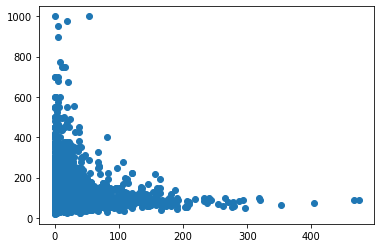

In [ ]:
plt.scatter(X.number_of_reviews, y)

### Create Correlation Coefficients

In [ ]:
# concatenate X and y
df_clean = pd.concat([X, y], axis=1)

In [ ]:
from _plotly_utils.basevalidators import DataArrayValidator
df_corr = df_clean.corr(method='pearson')

#create DataFrame
corr_coef = pd.DataFrame(df_corr.price)
# drop last row (price)
corr_price = corr_coef.drop('price')

#create column with absolute value
corr_price['abs'] = df_corr.price.abs()
# sort by absolute value
corr_sort = corr_price.sort_values(by='abs', ascending=False)

In [ ]:
fig = px.bar(corr_sort, x=corr_sort.index[:20], y=corr_sort.price[:20], labels={'y':'Value', 'x': 'Correlation Coefficients'})
fig.update_layout(title_text='Top 20 Correlation Coefficients for Airbnb Prices')
fig.show()

In [ ]:
fig = px.bar(corr_sort, x=corr_sort.index[:10], y=corr_sort.price[:10], 
             labels={'y':'Value', 'x': 'Correlation Coefficients'},
             width=600, height=400)
fig.update_layout(title_text='Top 10 Correlation Coefficients for Airbnb Prices')
fig.show()

Overall the coefficients make sense. E.g. an entire home has a positive influence to the price, where a private room or shared room correlate to an lower price. Also the correlation to the different bed types is reasonable. The coefficient for the number of reviews is negative. Looking at the scatter plot above, shows that the expensive homestay only have a few reviews, where the more affordable ones tend to have more.

# Popular Neighbourhoods in Seattle

In [ ]:
pop_nbh = df.groupby('neighbourhood').count().id
top20_nbh = pop_nbh.sort_values(ascending=False)[:20]

In [ ]:
fig = px.bar(top20_nbh, x=top20_nbh.index, y=top20_nbh.values, labels={'y':'Counts', 'x': 'Neighbourhood'})
fig.update_layout(title_text='Top 20 Most Popular Neighbourhoods in Seattle')
fig.show()

In [ ]:
fig = px.bar(top20_nbh, x=top20_nbh.index[:10], y=top20_nbh.values[:10],
             labels={'y':'Counts', 'x': 'Neighbourhood'},
             width=600, height=400)
fig.update_layout(title_text='Top 10 Most Popular Neighbourhoods in Seattle')
fig.show()

# Best time of the year to visit Seattle

In [ ]:
# convert price column to float:
data.price = data.price.str.replace('$', '')
data.price = data.price.str.replace(',', '')
data.price = pd.to_numeric(data.price)
data.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [ ]:
print(f"{data.price.isna().values.sum()} of {data.shape[0]} are NaN ({data.price.isna().values.sum()*100/data.shape[0]:.3}%)")

459028 of 1393570 are NaN (32.9%)


In [ ]:
# convert date column to datetime
data.date = pd.to_datetime(data.date)

In [ ]:
mean_price = data.groupby(data.date.dt.month).price.mean()
month_avail = data[data.available=='t'].groupby(data.date.dt.month).available.value_counts()
month_avail

px.bar(month_avail, x=month_avail.index.get_level_values(0), y=month_avail.values, color=mean_price)

fig = px.bar(month_avail,  x=month_avail.index.get_level_values(0), y=month_avail.values, color=mean_price,
             labels={'y':'Availability', 'x': 'Months of 2016', 'color': 'Mean Price [$]'},
             width=600, height=400)
fig.update_layout(title_text='Availability and Pricing in Seattle in 2016')
fig.update_xaxes(tickvals=[1,2,3,4,5,6,7,8,9,10,11,12])
fig.show()